In [725]:
import numpy as np
#import math 
from matplotlib import gridspec
import matplotlib.pyplot as plt
from scipy import signal

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\nadim\Miniconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'fft', 'split', 'fft2', 'test', 'number']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## GPGN 411: Advanced Gravity and Magnetic Exploration

## Lab Exercise 05: Fourier Transform of Potential-field Data Using Fast Fourier Transform

### Nadima Dwihusna and Felicia Nurindrawati

### Due: Tuesday (10/24/2017)



## A. Objective of the Lab

The objective of the lab is to develop a code for applying Fourier Transform to gridded potential data (i.e., spaced uniformly in both directions) and examine the power spectrum of gravity gradient data modeled in lab02, and that of the magnetic data calculated from lab03. 


## B. Background

**Discrete Fourier Transform:**

In potential-field, the discrete Fourier Transform (DFT) is used to approximate the Fourier Transform (integral form) and carry out the modeling and processing accordingly. Typically, the DFT is implemented numerically by the Fast Fourier Transform (FFT) method, which is ubiquitous in applied sciences and engineering.

For simplicity, the data dimensions are assumed to be integer power of 2. Then the wavenumbers are given by the following:

$$ \omega_x = m \frac{2\pi}{M\Delta x}, m=-kx+1, ..., 0, kx, kx = M/2$$

$$ \omega_y = n \frac{2\pi}{N\Delta y}, n=-ky+z, ..., ky, ky=N/2$$

where $M$ and $N$ are the number of points in x and y direction respectively and they are both integer powers of 2 as noted above, and $\Delta x$ and $\Delta y$ are the sampling intervals in x- and y- directions, respectively. Most data set would have identical intervals in both directions (which is the case for the data modelled in Lab 02 and Lab 03.

As noted in class, the right-hand coordinate system with z-axis point down and x-axis pointing north is used.

**FFT routines have some peculiar properties:**
1. It assumes that the input data series starts with $0$ location (or time) and covers $M$ points (for 1D scenerios, or one dimension of the multidimensional data set). So the first $1+M/2$ points input into an FFT routine should be the second "half" of the series. To obtain the correct phase, the data must be **folded** to follow this assumption as discussed in class.
2. The output of the FFT routine is also ordered in this way: the first element in the array is the zero-wavenumber point, and $(1+M/2)$'th element is the Nyquist point, then the next points is Nyquist plus one wavenumber interval. So, to obtain the correct Fourier Transform, the output must be re-ordered back to the sequence that begins with the negative wavenumber and end at Nyquist wavenumber which is referred to as **unfolding**.

## C. Tasks

### Task 1

Develop a code for performing FFT a 2D data map, assuming that each dimension is an integer power of 2.The code should consist of the following components.

#### A. Input the arbitrary 2D data map

In [726]:
num = 0
count = 0 
fname = "inputFile2D.txt"
with open(fname, 'r') as f:
    num = f.readline()

matrixInput = np.zeros((int(num),int(num)))

with open(fname, 'r') as file:
    next(file)
    for i in range(int(num)):
        data = file.readline()
        matrixInput[i, :] = data.split('\t')
print('Input:')
print(matrixInput)

Input:
[[  1.   2.   3.   4.]
 [  5.   6.   7.   8.]
 [  9.  10.  11.  12.]
 [ 13.  14.  15.  16.]]


#### B. Calculate the wavenumbers in both spatial directions

In [727]:
M = int(num)
N = int(num)

kx = int(M/2)
ky = int(N/2)

dx = 1
dy = 1

m = np.linspace(-kx+1, kx, (2*kx))
n = np.linspace(-ky+1, ky, (2*ky))


wx = m*2*np.pi/(M*dx)
wy = n*2*np.pi/(N*dy)

print('wx:')
print(wx)
print('wy:')
print(wy)

wx:
[-1.57079633  0.          1.57079633  3.14159265]
wy:
[-1.57079633  0.          1.57079633  3.14159265]


#### C. Fold the array in 2D

In [728]:
n = int(num)
A = matrixInput
s = (M/2) 

def foldonce2D(A, n):
    Ashift = np.zeros((n,n))
    Ashiftshift = np.zeros((n,n))
    shift = 1
    for i in range(n):
        temp = A[i,0]

        for j in range(n):
            if j == n-1:
                Ashift[i,n-1] = temp
            else:
                Ashift[i,j] = A[i, j+shift]

    for i in range(n):
        temprow = Ashift[0,:]
        if i == n-1:
            Ashiftshift[n-1,:] = temprow
        else:
            Ashiftshift[i,:] = Ashift[i+shift,:]
    return Ashiftshift

for i in range(int(s-1)):
    folded = foldonce2D(A, n)
    A = folded
print(folded)

[[  6.   7.   8.   5.]
 [ 10.  11.  12.   9.]
 [ 14.  15.  16.  13.]
 [  2.   3.   4.   1.]]


#### D. Apply fast Fourier transform routine to obtain the Fourier transform of the folded data

In [729]:
fft = np.fft.fft2(folded)
print(fft)

[[ 136. +0.j   -8. -8.j    8. +0.j   -8. +8.j]
 [ -32.-32.j    0. +0.j    0. +0.j    0. +0.j]
 [  32. +0.j    0. +0.j    0. +0.j    0. +0.j]
 [ -32.+32.j    0. +0.j    0. +0.j    0. +0.j]]


#### E. Unfold the Fourier transform

In [730]:
B = fft.imag
C = fft.real

def unfold2Donce(A, n):
    Ashift = np.zeros((n,n))
    Ashiftshift = np.zeros((n,n))
    shift = 1
    for i in range(n):
        temp = A[i,n-1]
        for j in range(n):
            if j == 0:
                Ashift[i,0] = temp
            else:
                Ashift[i,j] = A[i, j-shift]

    for i in range(n):
        temprow = Ashift[n-1,:]

        if i == 0:
            Ashiftshift[0,:] = temprow
        else:
            Ashiftshift[i,:] = Ashift[i-shift,:]

    return Ashiftshift

for i in range(int(s-1)):
    ufftR = unfold2Donce(C, n)
    ufftI = unfold2Donce(B,n)
    test = unfold2Donce(A,n)
    C = ufftR # Real Component
    B = ufftI # Imaginary Component
    A = test  # Gravity Gradient


print(test)

[[  1.   2.   3.   4.]
 [  5.   6.   7.   8.]
 [  9.  10.  11.  12.]
 [ 13.  14.  15.  16.]]


#### F. Plot the real and imaginary parts separately, and plot the power spectrum (approximated by the periodogram), as functions of wavenumbers in x-and y-directions. The power spectrum of potential-field data tends to span several orders of magnitude, so it is better to plot its common log value. 

C:\Users\nadim\Miniconda3\lib\site-packages\numpy\ma\core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


[[-1.57079633 -1.57079633 -1.57079633 -1.57079633]
 [ 0.          0.          0.          0.        ]
 [ 1.57079633  1.57079633  1.57079633  1.57079633]
 [ 3.14159265  3.14159265  3.14159265  3.14159265]]


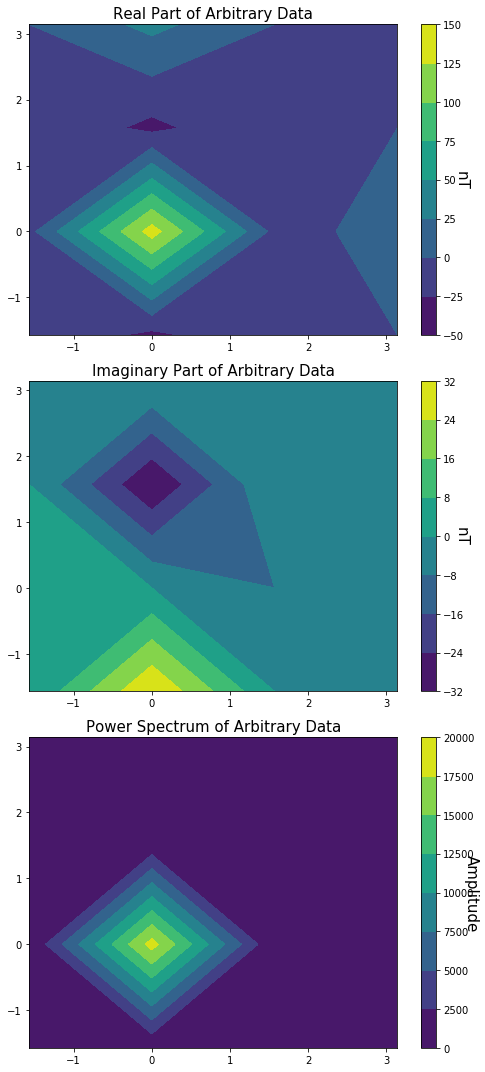

In [731]:
#wxm, wym = np.meshgrid(wx,wy)

###compl = ufftR + 1j*ufftI

#plt.figure(figsize=(7, 7))
#plt.subplot(211)
#plt.contourf(wxm, wym, ufftR)
#plt.title('Real Part ')
#plt.colorbar()

#plt.figure(figsize=(6, 6))
#plt.subplot(212)
#plt.contourf(wxm, wym, ufftI)
#plt.title('Imaginary Part')
#plt.colorbar()

#plt.figure(figsize=(12, 2))
#plt.subplot(213)
#plt.contourf(wxm, wym, np.log(ufftR**2))
#plt.title('Power Spectrum')
#plt.colorbar()

#plt.tight_layout()
#plt.show()

from matplotlib import gridspec
fig = plt.figure(figsize=(7,15))
[wxm, wym] = np.meshgrid(wx,wy)
gs = gridspec.GridSpec(3, 1)

compl = ufftR + 1j*ufftI

#print(wxm)

ax1 = fig.add_subplot(gs[0,0])
ax1 = plt.contourf(wxm, wym, ufftR)
ax1 = plt.title('Real Part of Arbitrary Data', size = 15)
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)


ax2 = fig.add_subplot(gs[1,0])
ax2 = plt.contourf(wxm, wym, ufftI)
ax1 = plt.title('Imaginary Part of Arbitrary Data', size = 15)
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[2,0])
ax3 = plt.contourf(wxm, wym, (compl**2))
ax1 = plt.title('Power Spectrum of Arbitrary Data', size = 15)
cbar = plt.colorbar()
cbar.set_label('Amplitude',size = 15, rotation=270)

print(wym)

plt.tight_layout()
plt.show()

### Task 2

Apply the code to three components of gravity gradient data from lab 02(e.g., Txx, Txy, and Tzz); observe and describe the two components of their Fourier transform and the corresponding power spectra.

#### A. Input 2D Data

In [732]:
#########Reading header###########
num = 0
count = 0 
store = 's'
number = ' '
with open('fileOutTaskIII.txt', 'r') as f:
    dat = f.readline()
    for i in dat:
        if (i == '#'):
            store = i
        else:
            number += i
num = int(number)
split = int(num)

numT= 0
countT= 0 
storeT= 's'
numberT = ' '
with open('fileOutTaskIII.txt', 'r') as file:
    dat = file.readline()
    for i in dat:
        if (i == '#'):
            storeT = i
        else:
            numberT += i
numT = int(numberT)
splitT = int(np.sqrt(numT))

#########Declare arrays#############
xi = np.zeros(split)
yi = np.zeros(split)
Txxi = np.zeros((split,split))
Txyi = np.zeros((split,split))
Tzzi = np.zeros((split,split))



################store to array##############
matrixInput = np.zeros((int(num)*int(num), 9))
with open('fileOutTaskIII.txt', 'r') as file:
    next(file)
    for i in range(int(num)*int(num)):
        data = file.readline()
        matrixInput[i, :] =data.split('\t')
    
    
Xinp = matrixInput[:,0]
Yinp = matrixInput[:,1]
Txx = matrixInput[:,3]
Txy = matrixInput[:,4]
Tzz = matrixInput[:,8]

count=0

for i in range((int(num))):
    for j in range((int(num))):
        xi[j] = Xinp[count]
        yi[j] = Yinp[count]
        Txxi[i,j] = Txx[count]
        Txyi[i,j] = Txy[count]
        Tzzi[i,j] = Tzz[count]
        count +=1
    



####  B. Calculate the wavenumbers in both spatial directions

In [733]:
M = int(num)
N = int(num)

kx = int(M/2)
ky = int(N/2)

dx = abs(Xinp[0]-Xinp[1])
dy = abs(Yinp[0]-Yinp[1])

m = np.linspace(-kx+1, kx, (M))
n = np.linspace(-ky+1, ky, (N))


wx = m*2*np.pi/(M*dx)
wy = n*2*np.pi/(N*dy)


### Applying code to Txx:

#### C. Fold the array in 2D

In [734]:
n = int(num)
A1 = Txxi 
s = (M/2) + 1 - 1

for i in range(int(s-1)):
    folded1 = foldonce2D(A1, n)
    A1 = folded1

#### D. Apply fast Fourier transform routine to obtain the Fourier transform of the folded data

In [735]:
fft1 = np.fft.fft2(folded1)
#print(np.shape(fft1))
#print(fft1)


#### E. Unfold the Fourier transform

In [736]:
B1 = fft1.imag 
C1 = fft1.real 
for i in range(int(s-1)):
    ufftR1 = unfold2Donce(C1, n)
    ufftI1 = unfold2Donce(B1,n)
    test1 = unfold2Donce(A1,n)
    C1 = ufftR1 # real part
    B1 = ufftI1 # imaginary part
    A1 = test1  # Gravity Gradient Component


#### F. Plot the real and imaginary parts separately, and plot the power spectrum (approximated by the periodogram), as functions of wavenumbers in x-and y-directions. The power spectrum of potential-field data tends to span several orders of magnitude, so it is better to plot its common log value.

C:\Users\nadim\Miniconda3\lib\site-packages\numpy\ma\core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


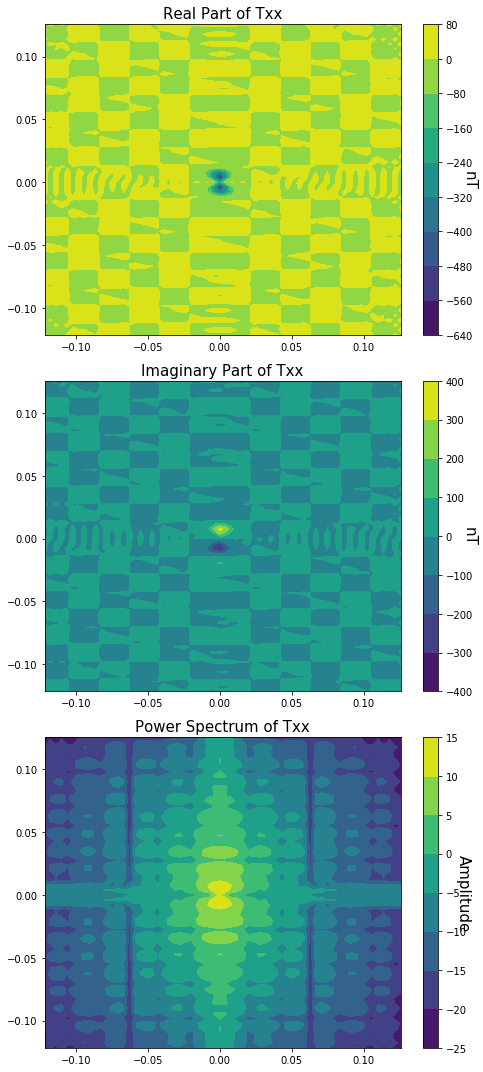

In [737]:
from matplotlib import gridspec
fig = plt.figure(figsize=(7,15))
[wxm, wym] = np.meshgrid(wx,wy)
gs = gridspec.GridSpec(3, 1)

compl1 = ufftR1 + 1j*ufftI1

#print(wxm)

ax1 = fig.add_subplot(gs[0,0])
ax1 = plt.contourf(wxm, wym, ufftR1)
ax1 = plt.title('Real Part of Txx', size = 15)
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)


ax2 = fig.add_subplot(gs[1,0])
ax2 = plt.contourf(wxm, wym, ufftI1)
ax1 = plt.title('Imaginary Part of Txx', size = 15)
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[2,0])
ax3 = plt.contourf(wxm, wym, np.log(compl1**2))
ax1 = plt.title('Power Spectrum of Txx', size = 15)
cbar = plt.colorbar()
cbar.set_label('Amplitude',size = 15, rotation=270)

plt.tight_layout()
plt.show()

### Applying code to Txy:

#### C. Fold the array in 2D

In [738]:
n = int(num)
A2 = Txyi 
s = (M/2) + 1 - 1

for i in range(int(s-1)):
    folded2 = foldonce2D(A2, n)
    A2 = folded2

#### D. Apply fast Fourier transform routine to obtain the Fourier transform of the folded data

In [739]:
fft2 = np.fft.fft2(folded2)
#print(np.shape(fft2))
#print(fft2)


#### E. Unfold the Fourier transform

In [740]:
B2 = fft2.imag 
C2 = fft2.real 
for i in range(int(s-1)):
    ufftR2 = unfold2Donce(C2, n)
    ufftI2 = unfold2Donce(B2,n)
    test2 = unfold2Donce(A2,n)
    C2 = ufftR2 # real part
    B2 = ufftI2 # imaginary part
    A2 = test2  # Gravity Gradient Component


#### F. Plot the real and imaginary parts separately, and plot the power spectrum (approximated by the periodogram), as functions of wavenumbers in x-and y-directions. The power spectrum of potential-field data tends to span several orders of magnitude, so it is better to plot its common log value.

C:\Users\nadim\Miniconda3\lib\site-packages\numpy\ma\core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


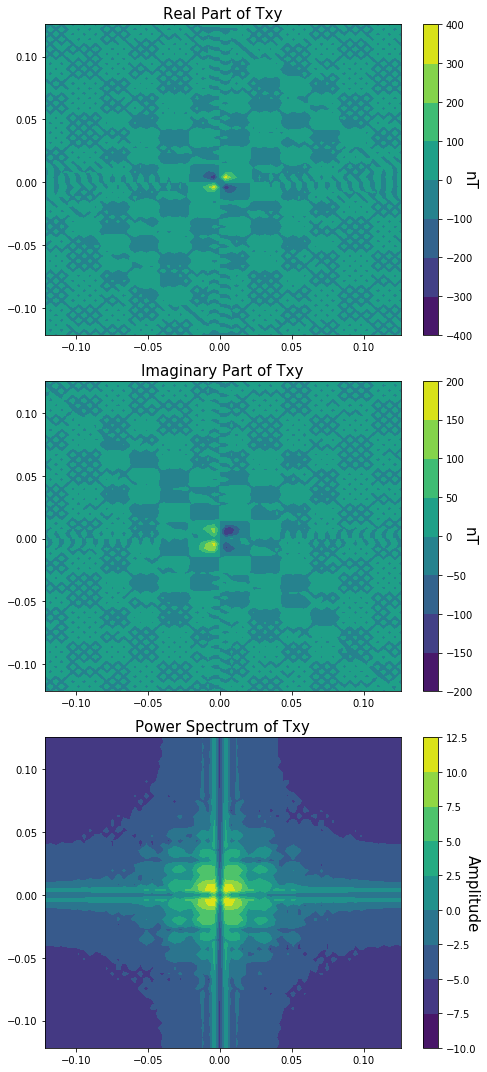

In [741]:
from matplotlib import gridspec
fig = plt.figure(figsize=(7,15))
[wxm, wym] = np.meshgrid(wx,wy)
gs = gridspec.GridSpec(3, 1)

compl2 = ufftR2 + 1j*ufftI2

#print(wxm)

ax1 = fig.add_subplot(gs[0,0])
ax1 = plt.contourf(wxm, wym, ufftR2)
ax1 = plt.title('Real Part of Txy', size = 15)
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)


ax2 = fig.add_subplot(gs[1,0])
ax2 = plt.contourf(wxm, wym, ufftI2)
ax1 = plt.title('Imaginary Part of Txy', size = 15)
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[2,0])
ax3 = plt.contourf(wxm, wym, np.log(compl2**2))
ax1 = plt.title('Power Spectrum of Txy', size = 15)
cbar = plt.colorbar()
cbar.set_label('Amplitude',size = 15, rotation=270)

plt.tight_layout()
plt.show()

### Applying code to Tzz:

#### C. Fold the array in 2D

In [742]:
n = int(num)
A3 = Tzzi 
s = (M/2) + 1 - 1

for i in range(int(s-1)):
    folded3 = foldonce2D(A3, n)
    A3 = folded3

#### D. Apply fast Fourier transform routine to obtain the Fourier transform of the folded data

In [743]:
fft3 = np.fft.fft2(folded3)
#print(np.shape(fft3))
#print(fft3)

#### E. Unfold the Fourier transform


In [744]:
B3 = fft3.imag 
C3 = fft3.real 
for i in range(int(s-1)):
    ufftR3 = unfold2Donce(C3, n)
    ufftI3 = unfold2Donce(B3,n)
    test3 = unfold2Donce(A3,n)
    C3 = ufftR3 # real part
    B3 = ufftI3 # imaginary part
    A3 = test3  # Gravity Gradient Component


#### F. Plot the real and imaginary parts separately, and plot the power spectrum (approximated by the periodogram), as functions of wavenumbers in x-and y-directions. The power spectrum of potential-field data tends to span several orders of magnitude, so it is better to plot its common log value.

C:\Users\nadim\Miniconda3\lib\site-packages\numpy\ma\core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


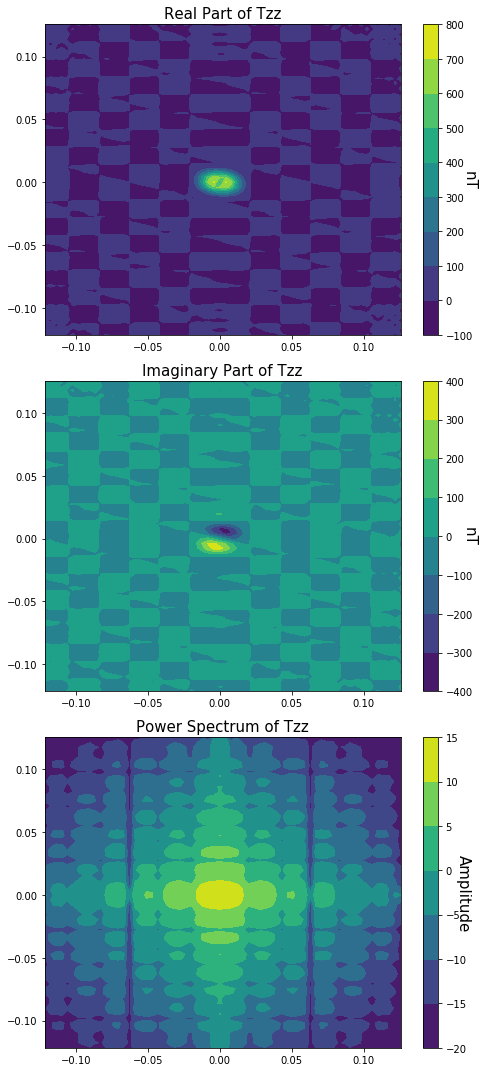

In [745]:
from matplotlib import gridspec
fig = plt.figure(figsize=(7,15))
[wxm, wym] = np.meshgrid(wx,wy)
gs = gridspec.GridSpec(3, 1)

compl3 = ufftR3 + 1j*ufftI3

#print(wxm)

ax1 = fig.add_subplot(gs[0,0])
ax1 = plt.contourf(wxm, wym, ufftR3)
ax1 = plt.title('Real Part of Tzz', size = 15)
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)


ax2 = fig.add_subplot(gs[1,0])
ax2 = plt.contourf(wxm, wym, ufftI3)
ax1 = plt.title('Imaginary Part of Tzz', size = 15)
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[2,0])
ax3 = plt.contourf(wxm, wym, np.log(compl3**2))
ax1 = plt.title('Power Spectrum of Tzz', size = 15)
cbar = plt.colorbar()
cbar.set_label('Amplitude',size = 15, rotation=270)

plt.tight_layout()
plt.show()

### Task 3

Apply the code to the first magnetic data set from Lab 04, and observe the Fourier transforms.

#### Input 2D Data

In [746]:
#########Reading header###########

count = 0 
store = 's'
number = ' '


#########Declare arrays#############

Baxi = np.zeros((split,split))
Bayi = np.zeros((split,split))
Bazi = np.zeros((split,split))
Tti = np.zeros((split,split))


################store to array##############
matrixInput = np.zeros((int(num)*int(num), 6))
with open('fileOutBa.txt', 'r') as file:
    for i in range(int(num)*int(num)):
        data = file.readline()
        matrixInput[i, :] = data.split('\t')


Bax= matrixInput[:,3]
Bay = matrixInput[:,4]
Baz = matrixInput[:,5]

count = 0
for i in range((int(num))):
    for j in range((int(num))):
        Baxi[i,j] = Bax[count]
        Bayi[i,j] = Bay[count]
        Bazi[i,j] = Baz[count]
        count +=1

####FOR deltaT

matrixInputT = np.zeros((int(num)*int(num), 4))
with open('fileOutTaskT.txt', 'r') as file:
    for i in range(int(num)*int(num)):
        data = file.readline()
        matrixInputT[i, :] = data.split('\t')
DT = matrixInputT[:,3]
count=0
for i in range((int(num))):
    for j in range((int(num))):
        Tti[i,j] = DT[count]
        count +=1

#### Fold the 2D Data

In [747]:
n = int(num)
Mag = Baxi

s = (M/2) + 1 - 1

for i in range(int(s-1)):
    folded = foldonce2D(Mag, n)
    Mag = folded
#FOR DELTAT

MagT = Tti
s = (M/2) + 1 - 1

for i in range(int(s-1)):
    foldedT = foldonce2D(MagT, n)
    MagT = foldedT
#print(foldedT)


### Applying Code for Bax

#### Apply FFT

In [748]:
fft = np.fft.fft2(folded)

####FOR DELTAT
fftT = np.fft.fft2(foldedT)
print(fftT)


[[ 0.36498881+0.j          0.96074793-1.38103609j  0.84976048-1.2602786j
  ...,  0.42659799+0.86983015j  0.84976048+1.2602786j
   0.96074793+1.38103609j]
 [-0.64528453-2.44759025j -0.09245584-2.90207619j -0.04961461-2.05615882j
  ...,  0.35657805+0.12554481j  0.44650386-0.15119469j
  -0.16711702-0.96691789j]
 [-1.06907869-1.22796928j -1.01880222-1.45003107j -0.69917791-1.16191484j
  ...,  0.04134608-0.15870703j -0.19047981-0.41289473j
  -0.65731982-0.79334926j]
 ..., 
 [-0.41825575+0.27470537j -0.31821294+0.18439136j -0.15236707+0.1119142j
  ..., -0.20394276+0.1243986j  -0.33111378+0.20353824j
  -0.39980213+0.2712499j ]
 [-1.06907869+1.22796928j -0.65731982+0.79334926j -0.19047981+0.41289473j
  ..., -0.42863744+0.67554077j -0.69917791+1.16191484j
  -1.01880222+1.45003107j]
 [-0.64528453+2.44759025j -0.16711702+0.96691789j  0.44650386+0.15119469j
  ..., -0.06625756+1.17999905j -0.04961461+2.05615882j
  -0.09245584+2.90207619j]]


#### Unfold the Data

In [749]:
B = fft.imag
C = fft.real
print(np.shape(B))
print(n)
for i in range(int(s-1)):
    ufftR = unfold2Donce(C, n)
    ufftI = unfold2Donce(B,n)
   # test = unfold2Donce(A,n)
    C = ufftR
    B = ufftI
   # A = test
####FOR DELTAT
BT = fftT.imag
CT = fftT.real
for i in range(int(s-1)):
    ufftRT = unfold2Donce(CT, n)
    ufftIT = unfold2Donce(BT,n)
   # testT = unfold2Donce(A,n)
    CT = ufftRT
    BT = ufftIT
   # A = test



(64, 64)
64


#### Plotting the Result

C:\Users\nadim\Miniconda3\lib\site-packages\numpy\ma\core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


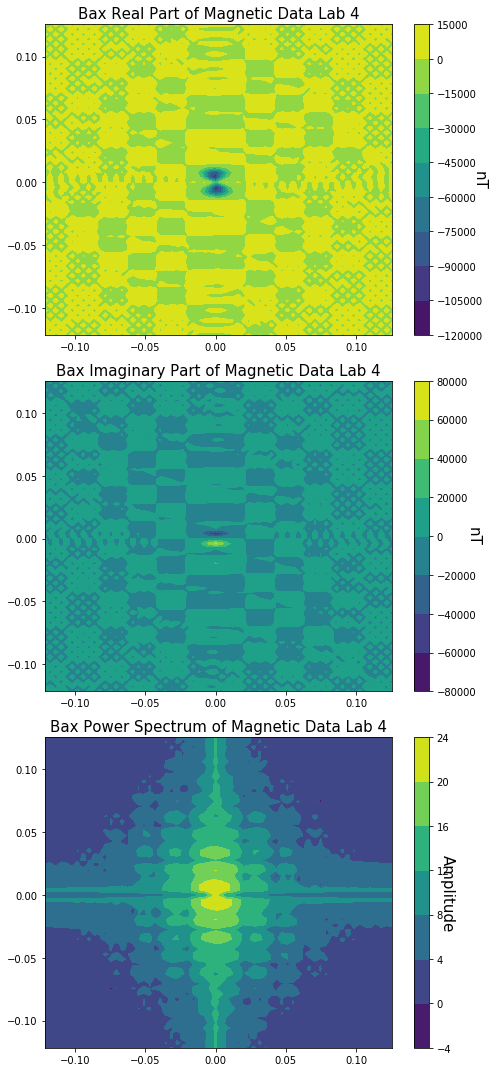

In [750]:
from matplotlib import gridspec
fig = plt.figure(figsize=(7,15))
[wxm, wym] = np.meshgrid(wx,wy)
gs = gridspec.GridSpec(3, 1)

compl = ufftR + 1j*ufftI

ax1 = fig.add_subplot(gs[0,0])
ax1 = plt.contourf(wxm, wym, ufftR)
plt.title('Bax Real Part of Magnetic Data Lab 4', size=15)
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)



ax2 = fig.add_subplot(gs[1,0])
ax2 = plt.contourf(wxm, wym, ufftI)
plt.title('Bax Imaginary Part of Magnetic Data Lab 4', size=15)
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax2 = fig.add_subplot(gs[2,0])
ax2 = plt.contourf(wxm, wym, np.log(compl**2))


cbar = plt.colorbar()
plt.title('Bax Power Spectrum of Magnetic Data Lab 4', size=15)
cbar.set_label('Amplitude',size = 15, rotation=270)
plt.tight_layout()
plt.show()

### Applying Code for Bay

### Applying Code for Baz

### Applying Code for $\Delta$X

## D. Description and Observations

#### A. How do the real and imaginary components differ in each case?


#### B. How do they change with the characteristics of the input data sets?


#### C. How do the power spectra change as with the wavenumber?



## E. Bonus Task (20% extra points)

Use lab03 code to calculate the magnetic data for a different prism (different depth and size), apply Fourier transform to the new data, and compare the results with that from the item-3 above. What are the major differences you observe in the power spectra?

In [752]:
###### Input the source parameters 

Xs = np.zeros(2)
Ys = np.zeros(2)
Zs = np.zeros(2)
num = 0
with open('prism.txt', 'r') as f:
    num = int(f.readline())
    data = f.readline()
    Xs = data.split('\t')
    Ys = data.split('\t')
    Zs = data.split('\t')


Xs1 = int(Xs[0])
Xs2 = int(Xs[1])
Ys1 = int(Ys[0])
Ys2 = int(Ys[1])
Zs1 = int(Zs[0])
Zs2 = int(Zs[1])

matrixInput = np.zeros(3)

with open('sourceParameters.txt', 'r') as file:
    next(file)
    dat = file.readline()
    matrixInput = dat.split('\t')

Mm = float(matrixInput[0])
Im = int(matrixInput[1])
Dm = int(matrixInput[2])

###### Input Bo information

matrixInp = np.zeros(3)
with open('inducingField.txt', 'r') as file:
    next(file)
    dat = file.readline()
    matrixInp = dat.split('\t')
    
I = int(matrixInp[0])
D = int(matrixInp[1])

###### Input the observation location

num = 0
count = 0 
with open('inputLocation.txt', 'r') as f:
    num = f.readline()

matrixInput = np.zeros((int(num),3))

with open('inputLocation.txt', 'r') as file:
    next(file)
    for i in range(int(num)):
        data = file.readline()
        matrixInput[i, :] =data.split('\t')

Xinp = matrixInput[:,0]
Yinp = matrixInput[:,1]
Zinp = matrixInput[:,2]

###### Calculate Bo and M

muo = 4*np.pi*10**(-7)

BoX = np.cos(I*np.pi/180)*np.cos(D*np.pi/180)
BoY = np.cos(I*np.pi/180)*np.sin(D*np.pi/180)
BoZ = np.sin(I*np.pi/180)
Bo = [BoX, BoY, BoZ]

Mx = Mm*np.cos(Im*np.pi/180)*np.cos(Dm*np.pi/180)
My = Mm*np.cos(Im*np.pi/180)*np.sin(Dm*np.pi/180)
Mz = Mm*np.sin(Im*np.pi/180)
M = [Mx, My, Mz]

xaxis = np.arange(len(Xinp))
yaxis = np.arange(len(Xinp))
Txx = np.zeros(len(Xinp))
Tyy = np.zeros(len(Xinp))
Tzz = np.zeros(len(Xinp))
Txy = np.zeros(len(Xinp))
Tyz = np.zeros(len(Xinp))
Txz = np.zeros(len(Xinp))

for i in range(len(Xinp)):
    Txx[i] = math.atan2((Yinp[i]-Ys2)*(Zinp[i]-Zs2),((Xinp[i]-Xs2)*math.sqrt((Xinp[i]-Xs2)**2 +(Yinp[i]-Ys2)**2+(Zinp[i]-Zs2)**2))) - math.atan2((Yinp[i]-Ys2)*(Zinp[i]-Zs2),((Xinp[i]-Xs1)*math.sqrt((Xinp[i]-Xs1)**2+(Yinp[i]-Ys2)**2+(Zinp[i]-Zs2)**2))) -  math.atan2((Yinp[i]-Ys1)*(Zinp[i]-Zs2),((Xinp[i]-Xs2)*math.sqrt((Xinp[i]-Xs2)**2+(Yinp[i]-Ys1)**2+(Zinp[i]-Zs2)**2))) + math.atan2((Yinp[i]-Ys1)*(Zinp[i]-Zs2),((Xinp[i]-Xs1)*math.sqrt((Xinp[i]-Xs1)**2+(Yinp[i]-Ys1)**2+(Zinp[i]-Zs2)**2))) - math.atan2((Yinp[i]-Ys2)*(Zinp[i]-Zs1),((Xinp[i]-Xs2)*math.sqrt((Xinp[i]-Xs2)**2+(Yinp[i]-Ys2)**2+(Zinp[i]-Zs1)**2))) + math.atan2((Yinp[i]-Ys2)*(Zinp[i]-Zs1),((Xinp[i]-Xs1)*math.sqrt((Xinp[i]-Xs1)**2+(Yinp[i]-Ys2)**2+(Zinp[i]-Zs1)**2)))  + math.atan2((Yinp[i]-Ys1)*(Zinp[i]-Zs1),((Xinp[i]-Xs2)*math.sqrt((Xinp[i]-Xs2)**2+(Yinp[i]-Ys1)**2+(Zinp[i]-Zs1)**2))) - math.atan2((Yinp[i]-Ys1)*(Zinp[i]-Zs1),((Xinp[i]-Xs1)*math.sqrt((Xinp[i]-Xs1)**2+(Yinp[i]-Ys1)**2+(Zinp[i]-Zs1)**2)))
    Tyy[i] = math.atan2((Xinp[i]-Xs2)*(Zinp[i]-Zs2),((Yinp[i]-Ys2)*math.sqrt((Yinp[i]-Ys2)**2+(Xinp[i]-Xs2)**2+(Zinp[i]-Zs2)**2))) - math.atan2((Xinp[i]-Xs2)*(Zinp[i]-Zs2),((Yinp[i]-Ys1)*math.sqrt((Yinp[i]-Ys1)**2+(Xinp[i]-Xs2)**2+(Zinp[i]-Zs2)**2))) -  math.atan2((Xinp[i]-Xs1)*(Zinp[i]-Zs2),((Yinp[i]-Ys2)*math.sqrt((Yinp[i]-Ys2)**2+(Xinp[i]-Xs1)**2+(Zinp[i]-Zs2)**2))) + math.atan2((Xinp[i]-Xs1)*(Zinp[i]-Zs2),((Yinp[i]-Ys1)*math.sqrt((Yinp[i]-Ys1)**2+(Xinp[i]-Xs1)**2+(Zinp[i]-Zs2)**2))) - math.atan2((Xinp[i]-Xs2)*(Zinp[i]-Zs1),((Yinp[i]-Ys2)*math.sqrt((Yinp[i]-Ys2)**2+(Xinp[i]-Xs2)**2+(Zinp[i]-Zs1)**2))) + math.atan2((Xinp[i]-Xs2)*(Zinp[i]-Zs1),((Yinp[i]-Ys1)*math.sqrt((Yinp[i]-Ys1)**2+(Xinp[i]-Xs2)**2+(Zinp[i]-Zs1)**2)))  + math.atan2((Xinp[i]-Xs1)*(Zinp[i]-Zs1),((Yinp[i]-Ys2)*math.sqrt((Yinp[i]-Ys2)**2+(Xinp[i]-Xs1)**2+(Zinp[i]-Zs1)**2))) - math.atan2((Xinp[i]-Xs1)*(Zinp[i]-Zs1),((Yinp[i]-Ys1)*math.sqrt((Yinp[i]-Ys1)**2+(Xinp[i]-Xs1)**2+(Zinp[i]-Zs1)**2)))
    Tzz[i] = math.atan2((Xinp[i]-Xs2)*(Yinp[i]-Ys2),((Zinp[i]-Zs2)*math.sqrt((Zinp[i]-Zs2)**2+(Xinp[i]-Xs2)**2+(Yinp[i]-Ys2)**2))) - math.atan2((Xinp[i]-Xs2)*(Yinp[i]-Ys2),((Zinp[i]-Zs1)*math.sqrt((Zinp[i]-Zs1)**2+(Xinp[i]-Xs2)**2+(Yinp[i]-Ys2)**2))) -  math.atan2((Xinp[i]-Xs1)*(Yinp[i]-Ys2),((Zinp[i]-Zs2)*math.sqrt((Zinp[i]-Zs2)**2+(Xinp[i]-Xs1)**2+(Yinp[i]-Ys2)**2))) + math.atan2((Xinp[i]-Xs1)*(Yinp[i]-Ys2),((Zinp[i]-Zs1)*math.sqrt((Zinp[i]-Zs1)**2+(Xinp[i]-Xs1)**2+(Yinp[i]-Ys2)**2))) - math.atan2((Xinp[i]-Xs2)*(Yinp[i]-Ys1),((Zinp[i]-Zs2)*math.sqrt((Zinp[i]-Zs2)**2+(Xinp[i]-Xs2)**2+(Yinp[i]-Ys1)**2))) + math.atan2((Xinp[i]-Xs2)*(Yinp[i]-Ys1),((Zinp[i]-Zs1)*math.sqrt((Zinp[i]-Zs1)**2+(Xinp[i]-Xs2)**2+(Yinp[i]-Ys1)**2)))  + math.atan2((Xinp[i]-Xs1)*(Yinp[i]-Ys1),((Zinp[i]-Zs2)*math.sqrt((Zinp[i]-Zs2)**2+(Xinp[i]-Xs1)**2+(Yinp[i]-Ys1)**2))) - math.atan2((Xinp[i]-Xs1)*(Yinp[i]-Ys1),((Zinp[i]-Zs1)*math.sqrt((Zinp[i]-Zs1)**2+(Xinp[i]-Xs1)**2+(Yinp[i]-Ys1)**2)))       
    Txy[i] = -math.log(math.sqrt((Xinp[i]-Xs2)**2+(Yinp[i]-Ys2)**2+(Zinp[i]-Zs2)**2)-(Zinp[i]-Zs2))+math.log(math.sqrt((Xinp[i]-Xs1)**2+(Yinp[i]-Ys2)**2+(Zinp[i]-Zs2)**2)-(Zinp[i]-Zs2))+math.log(math.sqrt((Xinp[i]-Xs2)**2+(Yinp[i]-Ys1)**2+(Zinp[i]-Zs2)**2)-(Zinp[i]-Zs2))-math.log(math.sqrt((Xinp[i]-Xs1)**2+(Yinp[i]-Ys1)**2+(Zinp[i]-Zs2)**2)-(Zinp[i]-Zs2))+math.log(math.sqrt((Xinp[i]-Xs2)**2+(Yinp[i]-Ys2)**2+(Zinp[i]-Zs1)**2)-(Zinp[i]-Zs1))-math.log(math.sqrt((Xinp[i]-Xs1)**2+(Yinp[i]-Ys2)**2+(Zinp[i]-Zs1)**2)-(Zinp[i]-Zs1))-math.log(math.sqrt((Xinp[i]-Xs2)**2+(Yinp[i]-Ys1)**2+(Zinp[i]-Zs1)**2)-(Zinp[i]-Zs1))+math.log(math.sqrt((Xinp[i]-Xs1)**2+(Yinp[i]-Ys1)**2+(Zinp[i]-Zs1)**2)-(Zinp[i]-Zs1))
    Txz[i] = -math.log(math.sqrt((Xinp[i]-Xs2)**2+(Zinp[i]-Zs2)**2+(Yinp[i]-Ys2)**2)-(Yinp[i]-Ys2))+math.log(math.sqrt((Xinp[i]-Xs1)**2+(Zinp[i]-Zs2)**2+(Yinp[i]-Ys2)**2)-(Yinp[i]-Ys2))+math.log(math.sqrt((Xinp[i]-Xs2)**2+(Zinp[i]-Zs1)**2+(Yinp[i]-Ys2)**2)-(Yinp[i]-Ys2))-math.log(math.sqrt((Xinp[i]-Xs1)**2+(Zinp[i]-Zs1)**2+(Yinp[i]-Ys2)**2)-(Yinp[i]-Ys2))+math.log(math.sqrt((Xinp[i]-Xs2)**2+(Zinp[i]-Zs2)**2+(Yinp[i]-Ys1)**2)-(Yinp[i]-Ys1))-math.log(math.sqrt((Xinp[i]-Xs1)**2+(Zinp[i]-Zs2)**2+(Yinp[i]-Ys1)**2)-(Yinp[i]-Ys1))-math.log(math.sqrt((Xinp[i]-Xs2)**2+(Zinp[i]-Zs1)**2+(Yinp[i]-Ys1)**2)-(Yinp[i]-Ys1))+math.log(math.sqrt((Xinp[i]-Xs1)**2+(Zinp[i]-Zs1)**2+(Yinp[i]-Ys1)**2)-(Yinp[i]-Ys1))
    Tyz[i] = -math.log(math.sqrt((Yinp[i]-Ys2)**2+(Zinp[i]-Zs2)**2+(Xinp[i]-Xs2)**2)-(Xinp[i]-Xs2))+math.log(math.sqrt((Yinp[i]-Ys1)**2+(Zinp[i]-Zs2)**2+(Xinp[i]-Xs2)**2)-(Xinp[i]-Xs2))+math.log(math.sqrt((Yinp[i]-Ys2)**2+(Zinp[i]-Zs1)**2+(Xinp[i]-Xs2)**2)-(Xinp[i]-Xs2))-math.log(math.sqrt((Yinp[i]-Ys1)**2+(Zinp[i]-Zs1)**2+(Xinp[i]-Xs2)**2)-(Xinp[i]-Xs2))+math.log(math.sqrt((Yinp[i]-Ys2)**2+(Zinp[i]-Zs2)**2+(Xinp[i]-Xs1)**2)-(Xinp[i]-Xs1))-math.log(math.sqrt((Yinp[i]-Ys1)**2+(Zinp[i]-Zs2)**2+(Xinp[i]-Xs1)**2)-(Xinp[i]-Xs1))-math.log(math.sqrt((Yinp[i]-Ys2)**2+(Zinp[i]-Zs1)**2+(Xinp[i]-Xs1)**2)-(Xinp[i]-Xs1))+math.log(math.sqrt((Yinp[i]-Ys1)**2+(Zinp[i]-Zs1)**2+(Xinp[i]-Xs1)**2)-(Xinp[i]-Xs1))
    

Bax = np.zeros(len(Xinp))
Bay = np.zeros((len(Xinp)))
Baz = np.zeros((len(Xinp)))
deltaT = np.zeros(len(Xinp))


for i in range(len(Xinp)):
    Bax[i] = (muo/(np.pi*4))*((Txx[i]*Mx) + (Txy[i]*My)+(Txz[i]*Mz))
    Bay[i] = (muo/(np.pi*4))*((Txy[i]*Mx) + (Tyy[i]*My)+(Tyz[i]*Mz))
    Baz[i] = (muo/(np.pi*4))*((Txz[i]*Mx) + (Tyz[i]*My)+(Tzz[i]*Mz))
    deltaT[i] = (BoX*Bax[i] + BoY*Bay[i] + BoZ*Baz[i])/50000

matrixOut = np.zeros((len(Xinp), 6))
count = 0
for i in range(len(Xinp)):
    matrixOut[i,0] = Xinp[i]
    matrixOut[i,1] = Yinp[i]
    matrixOut[i,2] = Zinp[i]
    matrixOut[i,3] = Bax[i]
    matrixOut[i,4] = Bay[i]
    matrixOut[i,5] = Baz[i]
    count += 1

np.savetxt('magTaskI.txt', matrixOut, delimiter='\t', header=str(count))

matrixOut = np.zeros((len(Xinp), 6))
count = 0
for i in range(len(Xinp)):
    matrixOut[i] = Xinp[i]
    matrixOut[i] = Yinp[i]
    matrixOut[i] = Zinp[i]
    matrixOut[i] = deltaT[i]/10**(-9)
    matrixOut[i] = deltaT[i]/10**(-9)
    matrixOut[i] = deltaT[i]/10**(-9)
    count += 1

np.savetxt('magTasktotal.txt', matrixOut, delimiter='\t', header=str(count))

Zs1 = 150
Zs2 = 450
Xs1 = -50
Xs2 = 400
Ys1 = -50 
Ys2 = 250
Xinp = np.arange(-755,800,25)
Yinp = np.arange(-755,800,25)
Zinp = 0

Txx = np.zeros((len(Xinp), len(Yinp)))
Tyy = np.zeros((len(Xinp), len(Yinp)))
Tzz = np.zeros((len(Xinp), len(Yinp)))
Txy = np.zeros((len(Xinp), len(Yinp)))
Tyz = np.zeros((len(Xinp), len(Yinp)))
Txz = np.zeros((len(Xinp), len(Yinp)))
matrixOut = np.zeros((len(Xinp)**2, 9))
count = 0


M = 2
I = 45
D = 25
Im = 45
Dm = 25

BoX = np.cos(I*np.pi/180)*np.cos(D*np.pi/180)
BoY = np.cos(I*np.pi/180)*np.sin(D*np.pi/180)
BoZ = np.sin(I*np.pi/180)
Bo = [BoX, BoY, BoZ]
Mx = Mm*np.cos(Im*np.pi/180)*np.cos(Dm*np.pi/180)
My = Mm*np.cos(Im*np.pi/180)*np.sin(Dm*np.pi/180)
Mz = Mm*np.sin(Im*np.pi/180)
M = [Mx, My, Mz]


for i in range(len(Xinp)):
    for j in range(len(Yinp)):
        Txx[i,j] = math.atan2((Yinp[j]-Ys2)*(Zinp-Zs2),((Xinp[i]-Xs2)*math.sqrt((Xinp[i]-Xs2)**2 +(Yinp[j]-Ys2)**2+(Zinp-Zs2)**2))) - math.atan2((Yinp[j]-Ys2)*(Zinp-Zs2),((Xinp[i]-Xs1)*math.sqrt((Xinp[i]-Xs1)**2+(Yinp[j]-Ys2)**2+(Zinp-Zs2)**2))) -  math.atan2((Yinp[j]-Ys1)*(Zinp-Zs2),((Xinp[i]-Xs2)*math.sqrt((Xinp[i]-Xs2)**2+(Yinp[j]-Ys1)**2+(Zinp-Zs2)**2))) + math.atan2((Yinp[j]-Ys1)*(Zinp-Zs2),((Xinp[i]-Xs1)*math.sqrt((Xinp[i]-Xs1)**2+(Yinp[j]-Ys1)**2+(Zinp-Zs2)**2))) - math.atan2((Yinp[j]-Ys2)*(Zinp-Zs1),((Xinp[i]-Xs2)*math.sqrt((Xinp[i]-Xs2)**2+(Yinp[j]-Ys2)**2+(Zinp-Zs1)**2))) + math.atan2((Yinp[j]-Ys2)*(Zinp-Zs1),((Xinp[i]-Xs1)*math.sqrt((Xinp[i]-Xs1)**2+(Yinp[j]-Ys2)**2+(Zinp-Zs1)**2)))  + math.atan2((Yinp[j]-Ys1)*(Zinp-Zs1),((Xinp[i]-Xs2)*math.sqrt((Xinp[i]-Xs2)**2+(Yinp[j]-Ys1)**2+(Zinp-Zs1)**2))) - math.atan2((Yinp[j]-Ys1)*(Zinp-Zs1),((Xinp[i]-Xs1)*math.sqrt((Xinp[i]-Xs1)**2+(Yinp[j]-Ys1)**2+(Zinp-Zs1)**2)))
        Tyy[i,j] = math.atan2((Xinp[i]-Xs2)*(Zinp-Zs2),((Yinp[j]-Ys2)*math.sqrt((Yinp[j]-Ys2)**2+(Xinp[i]-Xs2)**2+(Zinp-Zs2)**2))) - math.atan2((Xinp[i]-Xs2)*(Zinp-Zs2),((Yinp[j]-Ys1)*math.sqrt((Yinp[j]-Ys1)**2+(Xinp[i]-Xs2)**2+(Zinp-Zs2)**2))) -  math.atan2((Xinp[i]-Xs1)*(Zinp-Zs2),((Yinp[j]-Ys2)*math.sqrt((Yinp[j]-Ys2)**2+(Xinp[i]-Xs1)**2+(Zinp-Zs2)**2))) + math.atan2((Xinp[i]-Xs1)*(Zinp-Zs2),((Yinp[j]-Ys1)*math.sqrt((Yinp[j]-Ys1)**2+(Xinp[i]-Xs1)**2+(Zinp-Zs2)**2))) - math.atan2((Xinp[i]-Xs2)*(Zinp-Zs1),((Yinp[j]-Ys2)*math.sqrt((Yinp[j]-Ys2)**2+(Xinp[i]-Xs2)**2+(Zinp-Zs1)**2))) + math.atan2((Xinp[i]-Xs2)*(Zinp-Zs1),((Yinp[j]-Ys1)*math.sqrt((Yinp[j]-Ys1)**2+(Xinp[i]-Xs2)**2+(Zinp-Zs1)**2)))  + math.atan2((Xinp[i]-Xs1)*(Zinp-Zs1),((Yinp[j]-Ys2)*math.sqrt((Yinp[j]-Ys2)**2+(Xinp[i]-Xs1)**2+(Zinp-Zs1)**2))) - math.atan2((Xinp[i]-Xs1)*(Zinp-Zs1),((Yinp[j]-Ys1)*math.sqrt((Yinp[j]-Ys1)**2+(Xinp[i]-Xs1)**2+(Zinp-Zs1)**2)))
        Tzz[i,j] = math.atan2((Xinp[i]-Xs2)*(Yinp[j]-Ys2),((Zinp-Zs2)*math.sqrt((Zinp-Zs2)**2+(Xinp[i]-Xs2)**2+(Yinp[j]-Ys2)**2))) - math.atan2((Xinp[i]-Xs2)*(Yinp[j]-Ys2),((Zinp-Zs1)*math.sqrt((Zinp-Zs1)**2+(Xinp[i]-Xs2)**2+(Yinp[j]-Ys2)**2))) -  math.atan2((Xinp[i]-Xs1)*(Yinp[j]-Ys2),((Zinp-Zs2)*math.sqrt((Zinp-Zs2)**2+(Xinp[i]-Xs1)**2+(Yinp[j]-Ys2)**2))) + math.atan2((Xinp[i]-Xs1)*(Yinp[j]-Ys2),((Zinp-Zs1)*math.sqrt((Zinp-Zs1)**2+(Xinp[i]-Xs1)**2+(Yinp[j]-Ys2)**2))) - math.atan2((Xinp[i]-Xs2)*(Yinp[j]-Ys1),((Zinp-Zs2)*math.sqrt((Zinp-Zs2)**2+(Xinp[i]-Xs2)**2+(Yinp[j]-Ys1)**2))) + math.atan2((Xinp[i]-Xs2)*(Yinp[j]-Ys1),((Zinp-Zs1)*math.sqrt((Zinp-Zs1)**2+(Xinp[i]-Xs2)**2+(Yinp[j]-Ys1)**2)))  + math.atan2((Xinp[i]-Xs1)*(Yinp[j]-Ys1),((Zinp-Zs2)*math.sqrt((Zinp-Zs2)**2+(Xinp[i]-Xs1)**2+(Yinp[j]-Ys1)**2))) - math.atan2((Xinp[i]-Xs1)*(Yinp[j]-Ys1),((Zinp-Zs1)*math.sqrt((Zinp-Zs1)**2+(Xinp[i]-Xs1)**2+(Yinp[j]-Ys1)**2)))       
        Txy[i,j] = -math.log(math.sqrt((Xinp[i]-Xs2)**2+(Yinp[j]-Ys2)**2+(Zinp-Zs2)**2)-(Zinp-Zs2))+math.log(math.sqrt((Xinp[i]-Xs1)**2+(Yinp[j]-Ys2)**2+(Zinp-Zs2)**2)-(Zinp-Zs2))+math.log(math.sqrt((Xinp[i]-Xs2)**2+(Yinp[j]-Ys1)**2+(Zinp-Zs2)**2)-(Zinp-Zs2))-math.log(math.sqrt((Xinp[i]-Xs1)**2+(Yinp[j]-Ys1)**2+(Zinp-Zs2)**2)-(Zinp-Zs2))+math.log(math.sqrt((Xinp[i]-Xs2)**2+(Yinp[j]-Ys2)**2+(Zinp-Zs1)**2)-(Zinp-Zs1))-math.log(math.sqrt((Xinp[i]-Xs1)**2+(Yinp[j]-Ys2)**2+(Zinp-Zs1)**2)-(Zinp-Zs1))-math.log(math.sqrt((Xinp[i]-Xs2)**2+(Yinp[j]-Ys1)**2+(Zinp-Zs1)**2)-(Zinp-Zs1))+math.log(math.sqrt((Xinp[i]-Xs1)**2+(Yinp[j]-Ys1)**2+(Zinp-Zs1)**2)-(Zinp-Zs1))
        Txz[i,j] = -math.log(math.sqrt((Xinp[i]-Xs2)**2+(Zinp-Zs2)**2+(Yinp[j]-Ys2)**2)-(Yinp[j]-Ys2))+math.log(math.sqrt((Xinp[i]-Xs1)**2+(Zinp-Zs2)**2+(Yinp[j]-Ys2)**2)-(Yinp[j]-Ys2))+math.log(math.sqrt((Xinp[i]-Xs2)**2+(Zinp-Zs1)**2+(Yinp[j]-Ys2)**2)-(Yinp[j]-Ys2))-math.log(math.sqrt((Xinp[i]-Xs1)**2+(Zinp-Zs1)**2+(Yinp[j]-Ys2)**2)-(Yinp[j]-Ys2))+math.log(math.sqrt((Xinp[i]-Xs2)**2+(Zinp-Zs2)**2+(Yinp[j]-Ys1)**2)-(Yinp[j]-Ys1))-math.log(math.sqrt((Xinp[i]-Xs1)**2+(Zinp-Zs2)**2+(Yinp[j]-Ys1)**2)-(Yinp[j]-Ys1))-math.log(math.sqrt((Xinp[i]-Xs2)**2+(Zinp-Zs1)**2+(Yinp[j]-Ys1)**2)-(Yinp[j]-Ys1))+math.log(math.sqrt((Xinp[i]-Xs1)**2+(Zinp-Zs1)**2+(Yinp[j]-Ys1)**2)-(Yinp[j]-Ys1))
        Tyz[i,j] = -math.log(math.sqrt((Yinp[j]-Ys2)**2+(Zinp-Zs2)**2+(Xinp[i]-Xs2)**2)-(Xinp[i]-Xs2))+math.log(math.sqrt((Yinp[j]-Ys1)**2+(Zinp-Zs2)**2+(Xinp[i]-Xs2)**2)-(Xinp[i]-Xs2))+math.log(math.sqrt((Yinp[j]-Ys2)**2+(Zinp-Zs1)**2+(Xinp[i]-Xs2)**2)-(Xinp[i]-Xs2))-math.log(math.sqrt((Yinp[j]-Ys1)**2+(Zinp-Zs1)**2+(Xinp[i]-Xs2)**2)-(Xinp[i]-Xs2))+math.log(math.sqrt((Yinp[j]-Ys2)**2+(Zinp-Zs2)**2+(Xinp[i]-Xs1)**2)-(Xinp[i]-Xs1))-math.log(math.sqrt((Yinp[j]-Ys1)**2+(Zinp-Zs2)**2+(Xinp[i]-Xs1)**2)-(Xinp[i]-Xs1))-math.log(math.sqrt((Yinp[j]-Ys2)**2+(Zinp-Zs1)**2+(Xinp[i]-Xs1)**2)-(Xinp[i]-Xs1))+math.log(math.sqrt((Yinp[j]-Ys1)**2+(Zinp-Zs1)**2+(Xinp[i]-Xs1)**2)-(Xinp[i]-Xs1))

Bax = np.zeros((len(Xinp), len(Yinp)))
Bay = np.zeros((len(Xinp), len(Yinp)))
Baz = np.zeros((len(Xinp), len(Yinp)))
deltaT = np.zeros((len(Xinp), len(Yinp)))


matrixOutBa = np.zeros((len(Xinp)**2, 6))
MatrixOutT = np.zeros((len(Xinp)**2, 4))

for i in range(len(Xinp)):
    for j in range(len(Yinp)):
        Bax[i,j] = (muo/(np.pi*4))*((Txx[i,j]*Mx) + (Txy[i,j]*My)+(Txz[i,j]*Mz))/10**(-9)
        Bay[i,j] = (muo/(np.pi*4))*((Txy[i,j]*Mx) + (Tyy[i,j]*My)+(Tyz[i,j]*Mz))/10**(-9)
        Baz[i,j] = (muo/(np.pi*4))*((Txz[i,j]*Mx) + (Tyz[i,j]*My)+(Tzz[i,j]*Mz))/10**(-9)
        deltaT[i,j] = ((BoX*Bax[i,j] + BoY*Bay[i,j] + BoZ*Baz[i,j]))/50000
        matrixOutBa[count,0] = Xinp[i]
        MatrixOutT[count,0] = Xinp[i]
        matrixOutBa[count,1] =Yinp[j]
        MatrixOutT[count,1] = Yinp[j]
        matrixOutBa[count,2] =Zinp
        MatrixOutT[count,2] = Zinp
        matrixOutBa[count,3] = Bax[i,j]
        matrixOutBa[count,4] = Bay[i,j]
        matrixOutBa[count,5] = Baz[i,j]
        MatrixOutT[count,3] = deltaT[i,j]
        count += 1
        
head = str(count)

np.savetxt('BonusBa.txt', matrixOutBa, delimiter='\t', header=head)
np.savetxt('BonusT.txt', MatrixOutT, delimiter='\t', header=head)



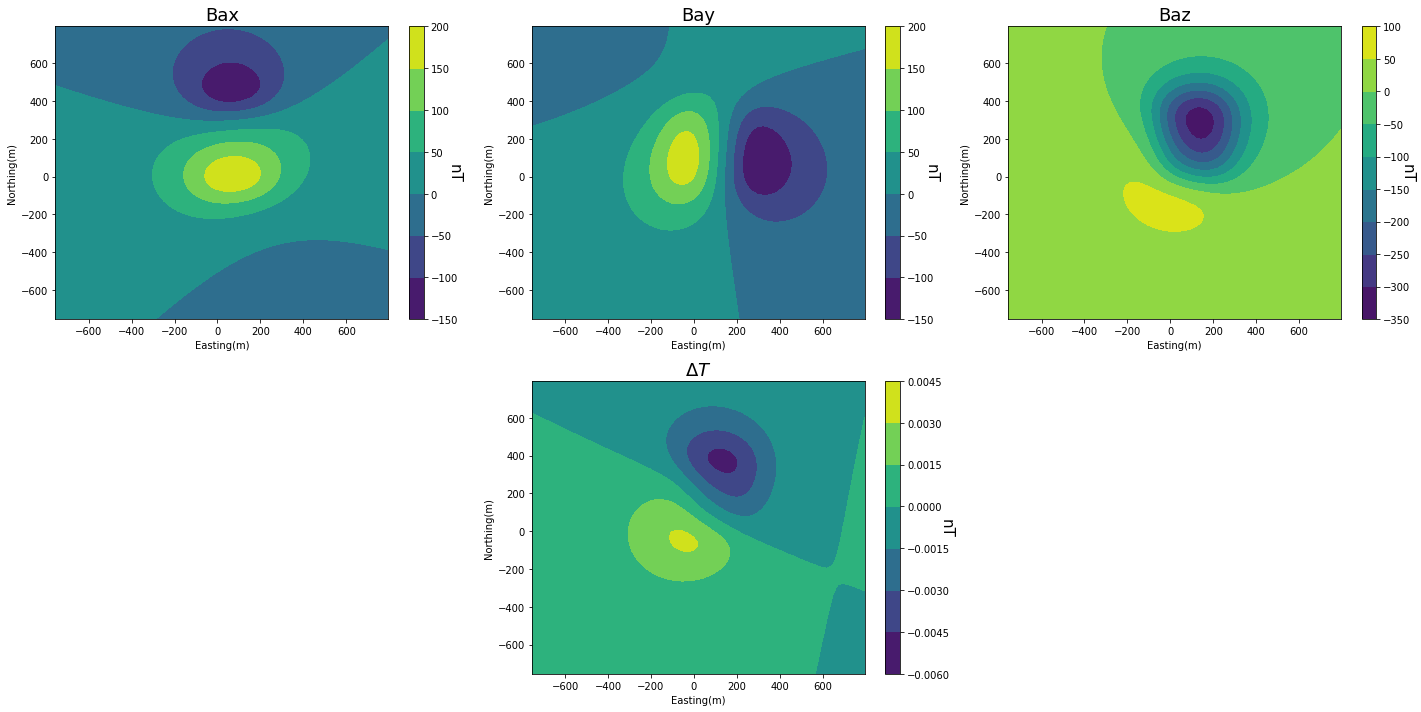

In [753]:
fig = plt.figure(figsize=(20, 10))
[x,y] = np.meshgrid(Xinp,Yinp)
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0,0])
ax1 = plt.contourf(x, y, -Bax)
ax1 = plt.title('Bax', size=18)
ax1 = plt.xlabel('Easting(m)')
ax1 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)


ax2 = fig.add_subplot(gs[0,1])
ax2 = plt.contourf(x, y, -Bay)
ax2 = plt.title('Bay', size=18)
ax2 = plt.xlabel('Easting(m)')
ax2 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[0,2])
ax3 = plt.contourf(x, y, -Baz)
ax3 = plt.title('Baz', size=18)
ax3 = plt.xlabel('Easting(m)')
ax3 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[1,1])
ax3 = plt.contourf(x, y, -deltaT)
ax3 = plt.title('$\Delta T$', size=18)
ax3 = plt.xlabel('Easting(m)')
ax3 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

plt.tight_layout()
plt.show()



In [754]:
BaxF = np.fft.fft2(Bax)
BayF = np.fft.fft2(Bay)
BazF = np.fft.fft2(Baz)
deltaTF = np.fft.fft2(deltaT)


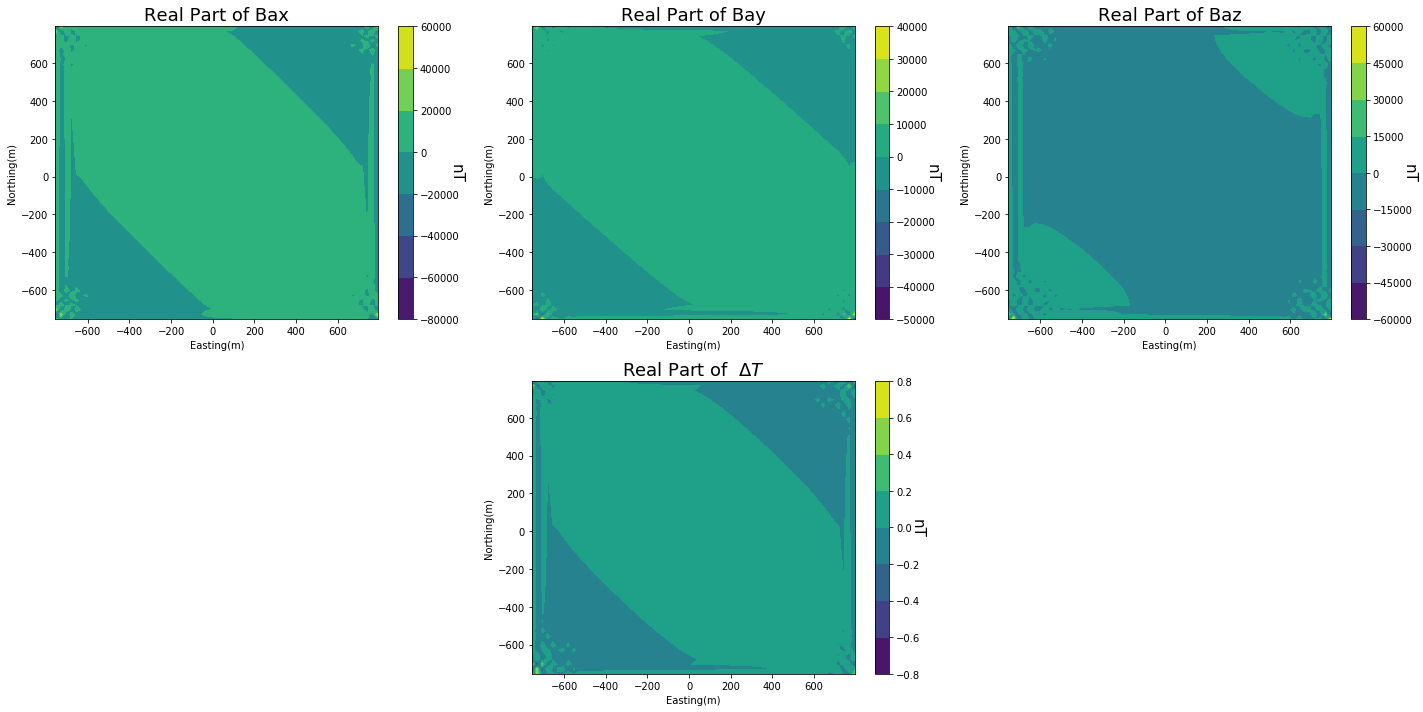

In [755]:


fig = plt.figure(figsize=(20, 10))
[x,y] = np.meshgrid(Xinp,Yinp)
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0,0])
ax1 = plt.contourf(x, y, (-BaxF.real))
ax1 = plt.title('Real Part of Bax', size=18)
ax1 = plt.xlabel('Easting(m)')
ax1 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)


ax2 = fig.add_subplot(gs[0,1])
ax2 = plt.contourf(x, y, -BayF.real)
ax2 = plt.title('Real Part of Bay', size=18)
ax2 = plt.xlabel('Easting(m)')
ax2 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[0,2])
ax3 = plt.contourf(x, y, -BazF.real)
ax3 = plt.title('Real Part of Baz', size=18)
ax3 = plt.xlabel('Easting(m)')
ax3 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[1,1])
ax3 = plt.contourf(x, y, -deltaTF.real)
ax3 = plt.title('Real Part of  $\Delta T$', size=18)
ax3 = plt.xlabel('Easting(m)')
ax3 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

plt.tight_layout()
plt.show()


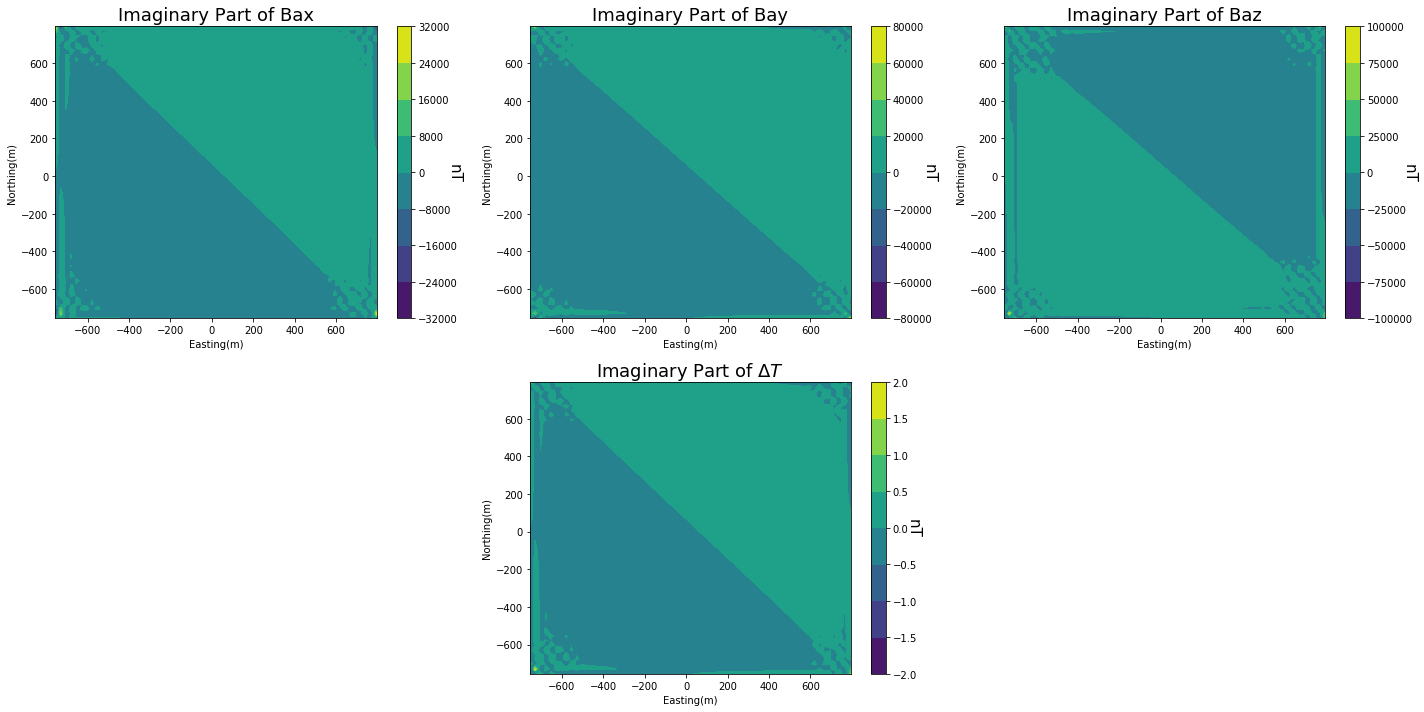

In [756]:

fig = plt.figure(figsize=(20, 10))
[x,y] = np.meshgrid(Xinp,Yinp)
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0,0])
ax1 = plt.contourf(x, y, -BaxF.imag)
ax1 = plt.title('Imaginary Part of Bax', size=18)
ax1 = plt.xlabel('Easting(m)')
ax1 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)


ax2 = fig.add_subplot(gs[0,1])
ax2 = plt.contourf(x, y, -BayF.imag)
ax2 = plt.title('Imaginary Part of Bay', size=18)
ax2 = plt.xlabel('Easting(m)')
ax2 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[0,2])
ax3 = plt.contourf(x, y, -BazF.imag)
ax3 = plt.title('Imaginary Part of Baz', size=18)
ax3 = plt.xlabel('Easting(m)')
ax3 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[1,1])
ax3 = plt.contourf(x, y, -deltaTF.imag)
ax3 = plt.title('Imaginary Part of $\Delta T$', size=18)
ax3 = plt.xlabel('Easting(m)')
ax3 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('nT',size = 15, rotation=270)

plt.tight_layout()
plt.show()

C:\Users\nadim\Miniconda3\lib\site-packages\numpy\ma\core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


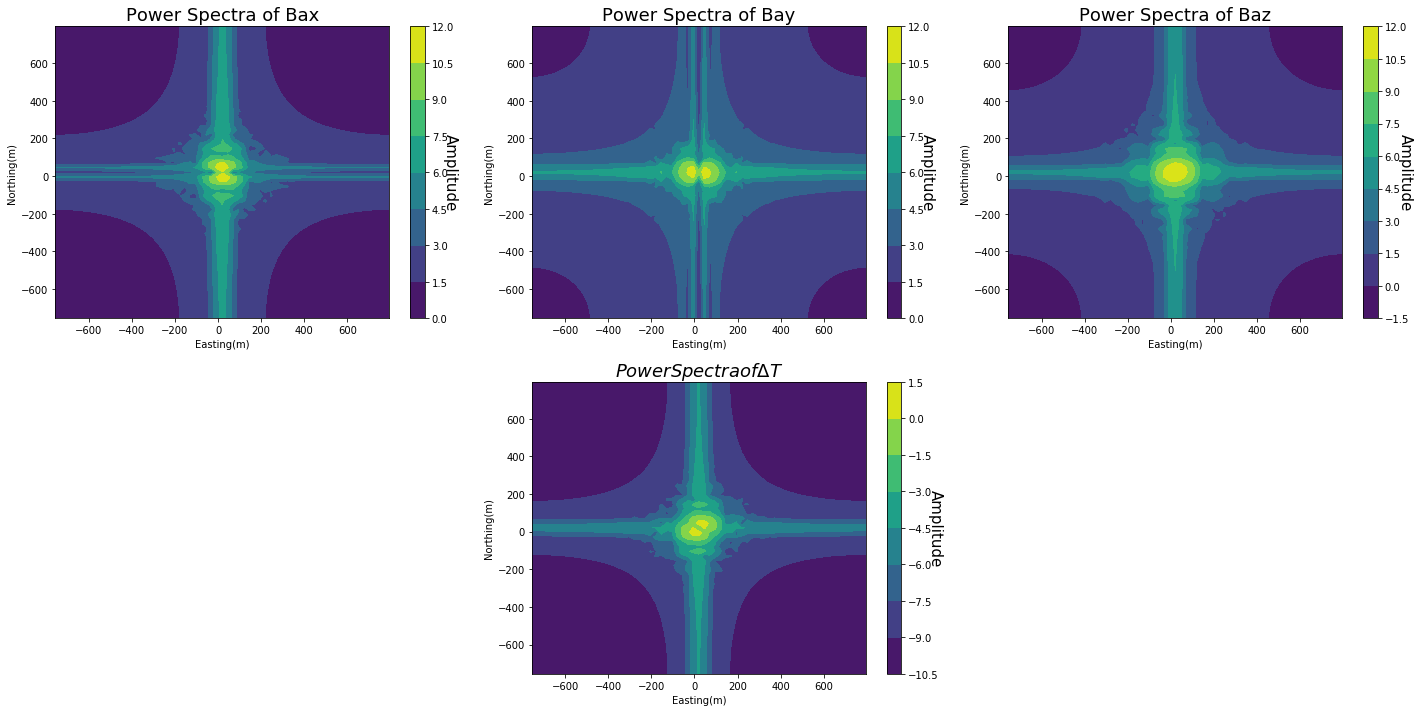

In [757]:
fig = plt.figure(figsize=(20, 10))
[x,y] = np.meshgrid(Xinp,Yinp)
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0,0])
ax1 = plt.contourf(x, y, np.log(np.fft.fftshift(np.fft.fft2(-Bax))))
ax1 = plt.title('Power Spectra of Bax', size=18)
ax1 = plt.xlabel('Easting(m)')
ax1 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('Amplitude',size = 15, rotation=270)


ax2 = fig.add_subplot(gs[0,1])
ax2 = plt.contourf(x, y, np.log(np.fft.fftshift(np.fft.fft2(-Bay))))
ax2 = plt.title('Power Spectra of Bay', size=18)
ax2 = plt.xlabel('Easting(m)')
ax2 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('Amplitude',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[0,2])
ax3 = plt.contourf(x, y, np.log(np.fft.fftshift(np.fft.fft2(-Baz))))
ax3 = plt.title('Power Spectra of Baz', size=18)
ax3 = plt.xlabel('Easting(m)')
ax3 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('Amplitude',size = 15, rotation=270)

ax3 = fig.add_subplot(gs[1,1])
ax3 = plt.contourf(x, y, np.log(np.fft.fftshift(np.fft.fft2(-deltaT))))
ax3 = plt.title('$Power Spectra of \Delta T$', size=18)
ax3 = plt.xlabel('Easting(m)')
ax3 = plt.ylabel('Northing(m)')
cbar = plt.colorbar()
cbar.set_label('Amplitude',size = 15, rotation=270)

plt.tight_layout()
plt.show()

#### What are the major differences you observe in the power spectra?